In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def load_data():
    #Loading the dataset
    print('loading the dataset')

    df = pd.read_csv('ridge_regression_dataset.csv', delimiter=',')
    X = df.values[:,:-1]
    y = df.values[:,-1]
    
    print('Split into Train and Test')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=10)

    print("Scaling all to [0, 1]")
    X_train, X_test = feature_normalization(X_train, X_test)
    X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))  # Add bias term
    X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1))))
    return X_train, y_train, X_test, y_test

In [5]:
X_train, y_train, X_test, y_test = load_data()

loading the dataset
Split into Train and Test
Scaling all to [0, 1]


In [4]:
#######################################
### Feature normalization
def feature_normalization(train, test):
    """Rescale the data so that each feature in the training set is in
    the interval [0,1], and apply the same transformations to the test
    set, using the statistics computed on the training set.

    Args:
        train - training set, a 2D numpy array of size(num_instances, num_features)
        test - test set, a 2D numpy array of size(num_instances, num_features)

    Returns:
        train_normalized - training set after normalization
        test_normalized - test set after normalization
    """
    # Remove constant features, using statistics of training set
    train = train[:, ~np.all(train[1:] == train[:-1], axis=0)]
    test = test[:, ~np.all(train[1:] == train[:-1], axis=0)]
    
    # Normalization with min-max
    max_train = train.max(axis=0)[None, :]
    min_train = train.min(axis=0)[None, :]
    
    train_normalized = (train - min_train) / (max_train - min_train)
    test_normalized = (test - min_train) / (max_train - min_train)
    
    return train_normalized, test_normalized

In [6]:
#######################################
### The square loss function
def compute_square_loss(X, y, theta):
    """
    Given a set of X, y, theta, compute the average square loss for predicting y with X*theta.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D array of size(num_features)

    Returns:
        loss - the average square loss, scalar
    """
    #TODO
    m = y.shape[0]
    y = y.reshape((y.shape[0], 1))
    
    return (1/m * (X @ theta - y).T @ (X @ theta - y))[0, 0]

In [7]:
# Test

theta = np.random.randn(X_train.shape[1])
compute_square_loss(X_train, y_train, theta)

20.276179184996607

In [18]:
#######################################
### The gradient of the square loss function
def compute_square_loss_gradient(X, y, theta):
    """
    Compute the gradient of the average square loss(as defined in compute_square_loss), at the point theta.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)

    Returns:
        grad - gradient vector, 1D numpy array of size(num_features)
    """
    
    m = y.shape[0]
    y = y.reshape((-1, 1))
    
    return ((2/m) * X.T @ (X @ theta - y)).reshape(-1)

In [19]:
# Test

theta = np.random.randn(X_train.shape[1], 1)
compute_square_loss_gradient(X_train, y_train, theta)

array([-0.66279064, -0.89502599, -0.99573447, -0.84580333, -0.13876649,
       -0.09770549, -0.09416025, -0.09416025, -0.32937889, -0.31261692,
       -0.13864523,  0.21399108,  0.71685532,  0.99378386,  0.02410214,
       -0.12751274,  0.02164121,  0.04562241, -0.43139973, -0.43139973,
       -0.43139973, -0.28679871, -0.28679871, -0.28679871, -0.22457812,
       -0.22457812, -0.22457812, -0.19643296, -0.19643296, -0.19643296,
       -0.18103247, -0.18103247, -0.18103247,  0.16411714,  0.16411714,
        0.16411714,  0.03086483,  0.03086483,  0.03086483, -0.04343164,
       -0.04343164, -0.04343164, -0.07768789, -0.07768789, -0.07768789,
       -0.09664791, -0.09664791, -0.09664791, -0.51830624])

In [20]:
#######################################
### Gradient checker
#Getting the gradient calculation correct is often the trickiest part
#of any gradient-based optimization algorithm. Fortunately, it's very
#easy to check that the gradient calculation is correct using the
#definition of gradient.
#See http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization
def grad_checker(X, y, theta, epsilon=0.01, tolerance=1e-4):
    """Implement Gradient Checker
    Check that the function compute_square_loss_gradient returns the
    correct gradient for the given X, y, and theta.

    Let d be the number of features. Here we numerically estimate the
    gradient by approximating the directional derivative in each of
    the d coordinate directions:
(e_1 =(1,0,0,...,0), e_2 =(0,1,0,...,0), ..., e_d =(0,...,0,1))

    The approximation for the directional derivative of J at the point
    theta in the direction e_i is given by:
(J(theta + epsilon * e_i) - J(theta - epsilon * e_i)) /(2*epsilon).

    We then look at the Euclidean distance between the gradient
    computed using this approximation and the gradient computed by
    compute_square_loss_gradient(X, y, theta).  If the Euclidean
    distance exceeds tolerance, we say the gradient is incorrect.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)
        epsilon - the epsilon used in approximation
        tolerance - the tolerance error

    Return:
        A boolean value indicating whether the gradient is correct or not
    """
    true_gradient = compute_square_loss_gradient(X, y, theta) #The true gradient
    num_features = theta.shape[0]
    approx_grad = np.zeros(num_features) #Initialize the gradient we approximate
    for i in range(num_features):
        h = np.zeros((num_features, 1))
        h[i] = 1
        approx_grad[i] = (compute_square_loss(X, y, theta + epsilon * h) 
                          - compute_square_loss(X, y, theta - epsilon * h)) / (2 * epsilon)
    
    return np.linalg.norm(approx_grad - true_gradient) <= tolerance

In [21]:
# Test

theta = np.random.randn(X_train.shape[1], 1)
grad_checker(X_train, y_train, theta)

True

In [22]:
#######################################
### Generic gradient checker
def generic_gradient_checker(X, y, theta, objective_func, gradient_func, 
                             epsilon=0.01, tolerance=1e-4):
    """
    The functions takes objective_func and gradient_func as parameters. 
    And check whether gradient_func(X, y, theta) returned the true 
    gradient for objective_func(X, y, theta).
    Eg: In LSR, the objective_func = compute_square_loss, and gradient_func = compute_square_loss_gradient
    """
    true_gradient = gradient_func(X, y, theta)
    num_features = theta.shape[0]
    approx_grad = np.zeros(num_features)
    for i in range(num_features):
        h = np.zeros((num_features, 1))
        h[i] = 1
        approx_grad[i] = (objective_func(X, y, theta + epsilon * h) 
                          - objective_func(X, y, theta - epsilon * h)) / (2 * epsilon)
    
    return np.linalg.norm(approx_grad - true_gradient) <= tolerance

In [23]:
# Test

theta = np.random.randn(X_train.shape[1], 1)
generic_gradient_checker(X_train, y_train, theta, compute_square_loss, compute_square_loss_gradient)

True

In [24]:
#######################################
### Batch gradient descent
def batch_grad_descent(X, y, alpha=0.1, num_step=1000, grad_check=False):
    """
    In this question you will implement batch gradient descent to
    minimize the average square loss objective.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        alpha - step size in gradient descent
        num_step - number of steps to run
        grad_check - a boolean value indicating whether checking the gradient when updating

    Returns:
        theta_hist - the history of parameter vector, 2D numpy array of size(num_step+1, num_features)
                     for instance, theta in step 0 should be theta_hist[0], theta in step(num_step) is theta_hist[-1]
        loss_hist - the history of average square loss on the data, 1D numpy array,(num_step+1)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_step + 1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_step + 1)  #Initialize loss_hist
    theta = np.zeros(num_features)  #Initialize theta
    theta_hist[0] = theta
    loss_hist[0] = compute_square_loss(X, y, theta.reshape((-1, 1)))
    
    for i in range(num_step):
        grad = compute_square_loss_gradient(X, y, theta.reshape((-1, 1)))
        
        # Do not update theta if grad_check fails
        if grad_check and not grad_checker(X, y, theta.reshape((-1, 1))):
            theta_hist[i+1, :] = theta
            loss_hist[i+1] = compute_square_loss(X, y, theta.reshape((-1, 1)))
            continue
        
        theta = theta - alpha * grad.reshape((1, -1))
        theta_hist[i+1, :] = theta
        loss_hist[i+1] = compute_square_loss(X, y, theta.reshape((-1, 1)))
    
    return theta_hist, loss_hist

In [25]:
# Test
t, l = batch_grad_descent(X_train, y_train, alpha=0.01, grad_check=False)
print(l)

[7.96151834 7.91242197 7.87772357 ... 2.78748976 2.78647298 2.78545842]


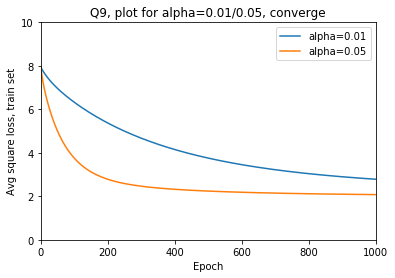

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in matmul
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in matmul


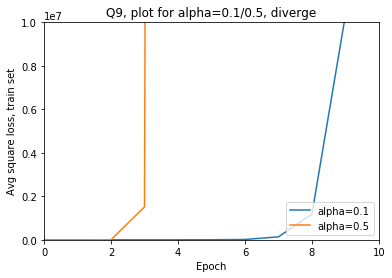

In [671]:
# Q9

plt.ylim([0, 10])
plt.xlim([0, 1000])
plt.ylabel('Avg square loss, train set')
plt.xlabel('Epoch')

for alpha in [.01, .05]:
    _, l = batch_grad_descent(X_train, y_train, alpha=alpha, grad_check=False)
    plt.plot([i for i in range(l.shape[0])], l, label='alpha={}'.format(alpha))

plt.legend(loc="upper right")
plt.title('Q9, plot for alpha=0.01/0.05, converge')
plt.savefig('fig/Q9_small_alpha.png')
plt.show()

plt.ylim([0, 10000000])
# plt.yscale('log')
plt.xlim([0, 10])
plt.ylabel('Avg square loss, train set')
plt.xlabel('Epoch')

for alpha in [.1, .5]:
    _, l = batch_grad_descent(X_train, y_train, alpha=alpha, grad_check=False)
    plt.plot([i for i in range(l.shape[0])], l, label='alpha={}'.format(alpha))

plt.legend(loc="lower right")
plt.title('Q9, plot for alpha=0.1/0.5, diverge')
plt.savefig('fig/Q9_big_alpha.png')
plt.show()

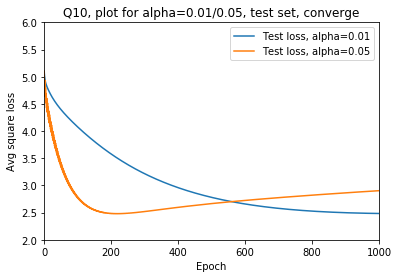

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in matmul
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in matmul


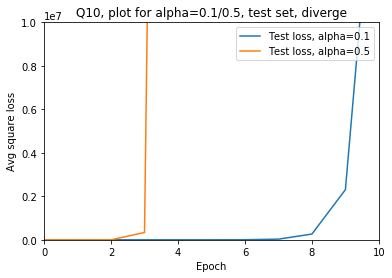

In [672]:
# Q10

plt.ylim([2, 6])
plt.xlim([0, 1000])
plt.ylabel('Avg square loss')
plt.xlabel('Epoch')

for alpha in [.01, .05]:
    # Grad descent, training loss
    theta_list, l = batch_grad_descent(X_train, y_train, alpha=alpha, grad_check=False)

    testing_loss = []
    for i in range(theta_list.shape[0]):
        testing_loss.append(compute_square_loss(X_test, y_test, theta_list[i].reshape(-1, 1)))

    plt.plot([i for i in range(len(testing_loss))], testing_loss, label='Test loss, alpha={}'.format(alpha))

plt.legend(loc="upper right")
plt.title('Q10, plot for alpha=0.01/0.05, test set, converge')
plt.savefig('fig/Q10_small_alpha.png')
plt.show()


plt.ylim([0, 10000000])
plt.xlim([0, 10])
plt.ylabel('Avg square loss')
plt.xlabel('Epoch')

for alpha in [.1, .5]:
    # Grad descent, training loss
    theta_list, _ = batch_grad_descent(X_train, y_train, alpha=alpha, grad_check=False)

    testing_loss = []
    for i in range(theta_list.shape[0]):
        testing_loss.append(compute_square_loss(X_test, y_test, theta_list[i, :]))

    plt.plot([i for i in range(len(testing_loss))], testing_loss, label='Test loss, alpha={}'.format(alpha))
    
plt.legend(loc="upper right")
plt.title('Q10, plot for alpha=0.1/0.5, test set, diverge')
plt.savefig('fig/Q10_big_alpha.png')
plt.show()

In [43]:
#######################################
### The gradient of regularized batch gradient descent
def compute_regularized_square_loss_gradient(X, y, theta, lambda_reg):
    """
    Compute the gradient of L2-regularized average square loss function given X, y and theta

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)
        lambda_reg - the regularization coefficient

    Returns:
        grad - gradient vector, 1D numpy array of size(num_features)
    """
    m = y.shape[0]
    y = y.reshape((-1, 1))
    print(X.shape, y.shape, theta.shape)
    print(X.T @ (X @ theta))
    
    return ((2/m) * X.T @ (X @ theta - y) + 2 * lambda_reg * theta).reshape(-1)

In [674]:
# Test

theta = np.random.randn(X_train.shape[1], 1)
compute_regularized_square_loss_gradient(X_train, y_train, theta, 0.01)

array([6.97889024, 6.26384598, 5.76283626, 5.43736604, 5.5356301 ,
       5.31308266, 4.8868966 , 4.91467549, 4.28733819, 3.42467297,
       2.89294998, 2.81893009, 2.46191186, 2.18898412, 0.60751146,
       0.38358098, 0.21111905, 0.04781531, 5.29615764, 5.28516932,
       5.30756909, 4.6340266 , 4.65076307, 4.61116154, 4.22716967,
       4.18880196, 4.20113572, 3.98296378, 3.97432999, 3.98331625,
       3.85611961, 3.91418223, 3.88994175, 1.97434438, 1.97843365,
       1.95413602, 2.58934584, 2.60977228, 2.57399072, 3.06409422,
       3.05138856, 3.01219371, 3.21898242, 3.23229885, 3.23236921,
       3.39684882, 3.33522244, 3.34999956, 7.11995679])

In [27]:
#######################################
### Regularized batch gradient descent
def regularized_grad_descent(X, y, alpha=0.05, lambda_reg=10**-2, num_step=1000):
    """
    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        alpha - step size in gradient descent
        lambda_reg - the regularization coefficient
        num_step - number of steps to run
    
    Returns:
        theta_hist - the history of parameter vector, 2D numpy array of size(num_step+1, num_features)
                     for instance, theta in step 0 should be theta_hist[0], theta in step(num_step+1) is theta_hist[-1]
        loss hist - the history of average square loss function without the regularization term, 1D numpy array.
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.zeros(num_features) #Initialize theta
    theta_hist = np.zeros((num_step+1, num_features)) #Initialize theta_hist
    loss_hist = np.zeros(num_step+1) #Initialize loss_hist
    theta_hist[0, :] = theta
    loss_hist[0] = compute_square_loss(X, y, theta.reshape((-1, 1)))
    
    for i in range(num_step):
        grad = compute_regularized_square_loss_gradient(X, y, theta.reshape((-1, 1)), lambda_reg)
        theta = theta - alpha * grad.reshape((1, -1))
        theta_hist[i+1, :] = theta
        loss_hist[i+1] = compute_square_loss(X, y, theta.reshape((-1, 1)))
    
    return theta_hist, loss_hist

In [28]:
# Test

t, l = regularized_grad_descent(X_train, y_train, alpha=0.05, lambda_reg=10**-2)
print(l)

[7.96151834 7.82651953 7.70402325 ... 2.28492578 2.28482008 2.28471467]


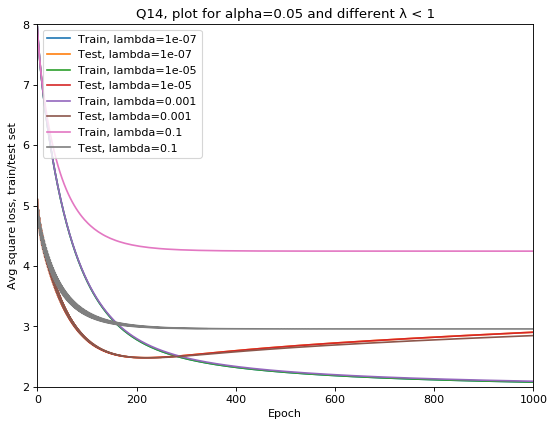

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in matmul
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in add
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in matmul


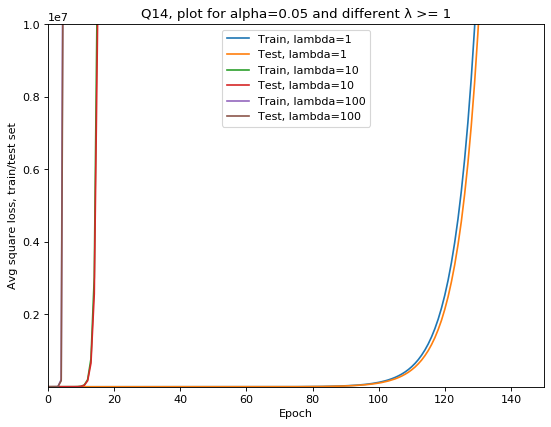

In [678]:
# Q14, choosing alpha=0.05

from matplotlib.pyplot import figure

# Lambda < 1

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.ylim([2, 8])
plt.xlim([0, 1000])
plt.ylabel('Avg square loss, train/test set')
plt.xlabel('Epoch')

alpha = 0.05
for lambda_reg in [10**-7, 10**-5, 10**-3, 10**-1]:
    # Grad descent, training loss
    theta_list, training_loss = regularized_grad_descent(X_train, y_train, alpha=alpha, lambda_reg=lambda_reg)
    plt.plot([i for i in range(l.shape[0])], training_loss, label='Train, lambda={}'.format(lambda_reg))

    testing_loss = []
    for i in range(theta_list.shape[0]):
        testing_loss.append(compute_square_loss(X_test, y_test, theta_list[i].reshape((-1, 1))))

    plt.plot([i for i in range(l.shape[0])], testing_loss, label='Test, lambda={}'.format(lambda_reg))

plt.legend(loc="upper left")
plt.title('Q14, plot for alpha=0.05 and different λ < 1')
plt.savefig('fig/Q14_alpha=0.05_small_lambda.png')
plt.show()


# Lambda >= 1

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.ylim([4, 10000000])
plt.xlim([0, 150])
plt.ylabel('Avg square loss, train/test set')
plt.xlabel('Epoch')

alpha = 0.05
for lambda_reg in [1, 10, 100]:
    # Grad descent, training loss
    theta_list, training_loss = regularized_grad_descent(X_train, y_train, alpha=alpha, lambda_reg=lambda_reg)
    plt.plot([i for i in range(l.shape[0])], training_loss, label='Train, lambda={}'.format(lambda_reg))

    testing_loss = []
    for i in range(theta_list.shape[0]):
        testing_loss.append(compute_square_loss(X_test, y_test, theta_list[i].reshape((-1, 1))))

    plt.plot([i for i in range(l.shape[0])], testing_loss, label='Test, lambda={}'.format(lambda_reg))

plt.legend(loc="upper center")
plt.title('Q14, plot for alpha=0.05 and different λ >= 1')
plt.savefig('fig/Q14_alpha=0.05_big_lambda.png')
plt.show()

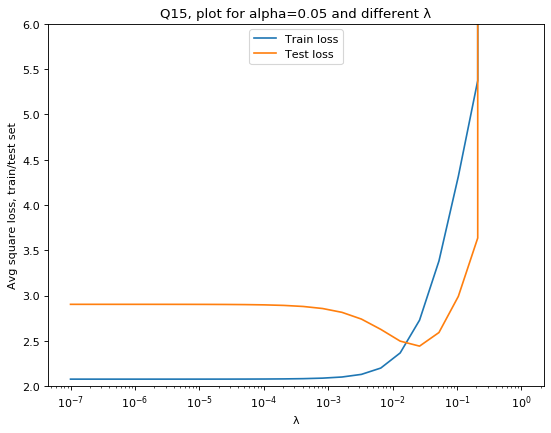

In [691]:
# Q15, various lambda

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.ylim([2, 6])
plt.xscale('log')
plt.ylabel('Avg square loss, train/test set')
plt.xlabel('λ')

alpha = 0.05
lambda_list = [10**-7]
while(lambda_list[-1] < 0.5):
    lambda_list.append(lambda_list[-1] * 2)
lambda_list.append(1)

plot_list_train = []
plot_list_test = []

for lambda_reg in lambda_list:
    # Grad descent, training loss
    theta_list, training_loss = regularized_grad_descent(X_train, y_train, alpha=alpha, lambda_reg=lambda_reg)
    plot_list_train.append(training_loss[-1])
    plot_list_test.append(compute_square_loss(X_test, y_test, theta_list[-1].reshape((-1, 1))))

plt.plot(lambda_list, plot_list_train, label='Train loss')
plt.plot(lambda_list, plot_list_test, label='Test loss')

plt.legend(loc="upper center")
plt.title('Q15, plot for alpha=0.05 and different λ')
plt.savefig('fig/Q15_alpha=0.05.png')
plt.show()

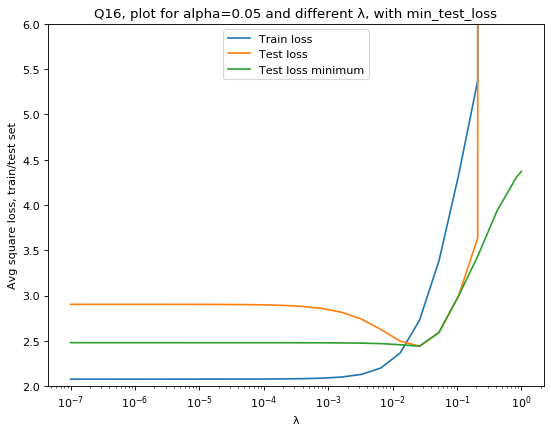

In [692]:
# Q16

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.ylim([2, 6])
plt.xscale('log')
plt.ylabel('Avg square loss, train/test set')
plt.xlabel('λ')

alpha = 0.05
lambda_list = [10**-7]
while(lambda_list[-1] < 0.5):
    lambda_list.append(lambda_list[-1] * 2)
lambda_list.append(1)

plot_list_train = []
plot_list_test = []
plot_list_test_min = []

for lambda_reg in lambda_list:
    # Grad descent, training loss
    theta_list, training_loss = regularized_grad_descent(X_train, y_train, alpha=alpha, lambda_reg=lambda_reg)
    plot_list_train.append(training_loss[-1])
    plot_list_test.append(compute_square_loss(X_test, y_test, theta_list[-1].reshape((-1, 1))))
    
    test_min_cur = float('inf')
    for theta in theta_list:
        test_min_cur = min(test_min_cur, compute_square_loss(X_test, y_test, theta.reshape((-1, 1))))
    plot_list_test_min.append(test_min_cur)
    
plt.plot(lambda_list, plot_list_train, label='Train loss')
plt.plot(lambda_list, plot_list_test, label='Test loss')
plt.plot(lambda_list, plot_list_test_min, label='Test loss minimum')

plt.legend(loc="upper center")
plt.title('Q16, plot for alpha=0.05 and different λ, with min_test_loss')
plt.savefig('fig/Q16_alpha=0.05.png')
plt.show()

In [69]:
#######################################
### Stochastic gradient descent
def stochastic_grad_descent(X, y, alpha=0.01, lambda_reg=10**-2, num_epoch=1000, eta0=False):
    """
    In this question you will implement stochastic gradient descent with regularization term

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        alpha - string or float, step size in gradient descent
                NOTE: In SGD, it's not a good idea to use a fixed step size. Usually it's set to 1/sqrt(t) or 1/t
                if alpha is a float, then the step size in every step is the float.
                if alpha == "1/sqrt(t)", alpha = 1/sqrt(t).
                if alpha == "1/t", alpha = 1/t.
        lambda_reg - the regularization coefficient
        num_epoch - number of epochs to go through the whole training set

    Returns:
        theta_hist - the history of parameter vector, 3D numpy array of size(num_epoch, num_instances, num_features)
                     for instance, theta in epoch 0 should be theta_hist[0], theta in epoch(num_epoch) is theta_hist[-1]
        loss hist - the history of loss function vector, 2D numpy array of size(num_epoch, num_instances)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.ones(num_features) #Initialize theta

    theta_hist = np.zeros((num_epoch, num_instances, num_features)) #Initialize theta_hist
    loss_hist = np.zeros((num_epoch, num_instances)) #Initialize loss_hist
    
    m = y.shape[0]
    for i in range(num_epoch):
        for j in range(m):
            # Get a random sample
            idx = np.random.randint(0, m)
            cur_X = X[idx, :]
            cur_y = np.asarray([y[idx]])
            grad = compute_regularized_square_loss_gradient(cur_X.reshape((1, -1)), cur_y, theta.reshape((-1, 1)), lambda_reg)
            theta = theta - alpha * grad.reshape((1, -1))
            theta_hist[i, j, :] = theta
            loss_hist[i, j] = compute_square_loss(X, y, theta.reshape((-1, 1)))
    
    return theta_hist, loss_hist

In [72]:
stochastic_grad_descent(X_train, y_train)

(1, 49) (1, 1) (49, 1)
[[42.87326701]]


TypeError: 'numpy.ndarray' object is not callable

In [71]:
#######################################
### The gradient of regularized batch gradient descent
def compute_regularized_square_loss_gradient(X, y, theta, lambda_reg):
    """
    Compute the gradient of L2-regularized average square loss function given X, y and theta

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)
        lambda_reg - the regularization coefficient

    Returns:
        grad - gradient vector, 1D numpy array of size(num_features)
    """
    m = y.shape[0]
    y = y.reshape((-1, 1))
    print(X.shape, y.shape, theta.shape)
    print(X @ theta)
    print(X.T(X @ theta))
    print(X.T.shape, (X @ theta).shape)
    
    return ((2/m) * X @ (X @ theta - y) + 2 * lambda_reg * theta).reshape(-1)